### A. Goldman, N. Puchkin, V. Shcherbakova, and U. Vinogradova

### Numerical experiments on Sberbank shares data set, described in the paper
### "A Contrastive Approach to Online Change Point Detection" (arXiv:2206.10143)

In [1]:
import numpy as np
from numpy.random import randn
from numpy.random import laplace
import pandas as pd
import torch
import matplotlib.pyplot as plt
from datetime import datetime

# Import the algorithms for comparison
from algorithms.contrastive_change_point import compute_test_stat_linear
from algorithms.contrastive_change_point import compute_test_stat_nn
from algorithms.fast_contrastive_change_point import compute_test_stat_ftal
from algorithms.kliep import compute_test_stat_kliep
from algorithms.m_statistic import compute_test_stat_mmd

import joblib

%matplotlib inline


In [2]:
%reload_ext autoreload
%autoreload 2

## Auxiliary functions

In [3]:
torch.manual_seed(1)

In [4]:
def plot_data_with_cp_sber(df, interval=[0,-1], changepoints=None):
    title = "Sberbank shares"


    fig, axes = plt.subplots(1, 1, squeeze=False)

    x = df.index
    y = df["<CLOSE>"]

    if interval != [0,-1]:
        x = x[interval[0]: interval[1]]
        y = y[interval[0]: interval[1]]

        if not changepoints is None:
            changepoints = changepoints[(changepoints >= interval[0]) & (changepoints <= interval[1])]

    plt.plot(x, y, color="#000066")

    if not changepoints is None:
            plt.vlines(x=changepoints, ymin=y.min(), ymax=y.max(), colors='#ff00bf', ls=':', lw=1.5)


    fig.suptitle(title)

In [5]:
def change_series_sber(df, type_change=None):
    if type_change is None:
        return df
    
    cols = ["<CLOSE>"]#df.columns[1:]
    new_df = pd.DataFrame(columns=['<DATE>'].extend(cols))
    new_df['<DATE>'] = df['<DATE>'][:-1]
    for c in cols:
        if type_change == 'log_simple':
            new_df[c] = (np.log1p(np.roll(df[c], -1)) - np.log1p(df[c]))[:-1]
        elif type_change == 'lin':
            new_df[c] = (np.roll(df[c], -1) - df[c])[:-1]
        else:
            new_df[c] = np.log1p(abs(np.roll(df[c], -1) -df[c]) / abs(df[c] + 1))[:-1]

    return new_df

### Sberbank shares data set

In [6]:
# Read the data
sber = pd.read_csv('data/SberbankShares/SBER_130523_230523_day.csv', sep=';')

sber.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<CLOSE>
0,SBER,D,20130523,0,105.55
1,SBER,D,20130524,0,103.08
2,SBER,D,20130527,0,102.87
3,SBER,D,20130528,0,104.10
4,SBER,D,20130529,0,99.96


In [7]:
sber_changed = change_series_sber(sber, type_change="lin")
sber_changed['datetime'] = sber_changed['<DATE>'].apply(lambda x: datetime.strptime(str(x), "%Y%m%d"))

In [8]:
change_points = np.array([
    180,
    398,
    540,
    920,
    1025,
    1200,
    1320,
    1700,
    2045,
    2110,
    2225,
    2400
    ])

In [10]:
df = sber_changed

In [11]:
# Split the data into the stationary part, validation part, and test part

# Stationary part: three parts of the time series without the change points.
# Used to tune the threshold
#
data = df['<CLOSE>'].values
data_stationary = [data[:181]]

# Validation part: a part with several change points to tune the hyperparameters
val_start = 0
val_end = 1500
data_val = data[val_start:val_end]

# Test part: check the performance of the procedures
test_start = 1500
data_test = data[test_start:]

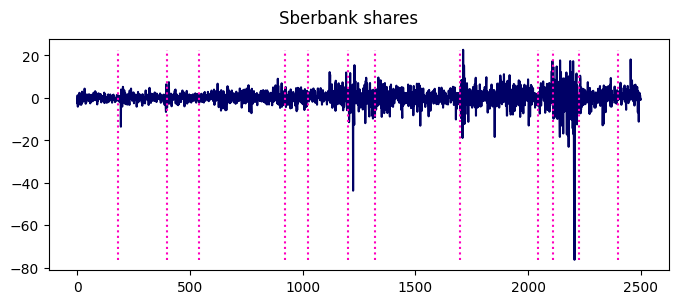

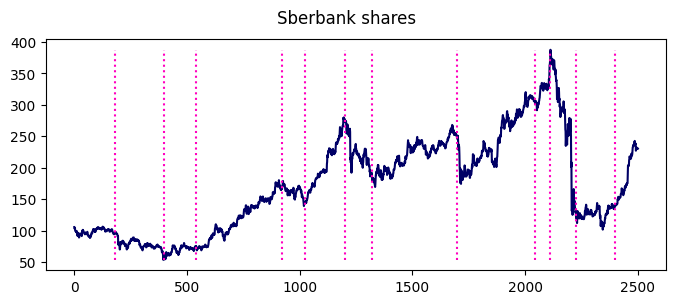

In [12]:
plt.rcParams["figure.figsize"] = (8,3)
plot_data_with_cp_sber(sber_changed, changepoints=change_points)
plt.show()
plot_data_with_cp_sber(sber, changepoints=change_points)

### Contrastive change point detection

#### With a class of neural networks

In [56]:
#TRAIN

verbose = True
min_diff = 10

#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    
S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_nn(ds, n_epochs=20, delta_max=70)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = np.max(S_stationary)

z = 5.21

#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Val change points:', change_points_val)

# Initialization of the test statistic
S_nn_train = np.empty(0)

# Initialization of the list of detected change points
change_points_nn = []

# Initialization of the delays array and
# the false alarms counter
delays_nn = np.empty(0)
current_change_point_ind = 0
false_alarms_nn = 0

# Initialization
st_nn = 0
new_st_nn = 0
    
while new_st_nn >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_nn, new_st_nn = compute_test_stat_nn(data_val[st_nn + 1:], threshold=z, n_epochs=20, delta_max=70)

    S_nn_train = np.append(S_nn_train, new_S_nn)

    st_nn += new_st_nn
    change_points_nn += [int(st_nn)]

    if(new_st_nn > 0):
        if verbose:  
            print('Detected change point:', st_nn)
            
        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_nn > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_nn += 1
        else:
            skipped_cp = 0
            
            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_nn:
                
                if skipped_cp > 0:
                    delays_nn = np.append(delays_nn, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1


                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_nn <= min_diff):
                delays_nn = np.append(delays_nn, np.array([0.0]), axis=0)


                if skipped_cp > 0:
                    delays_nn = np.append(delays_nn, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_nn = np.append(delays_nn,\
                                  np.array([st_nn - change_points_val[current_change_point_ind - 1]]), axis=0)
            
while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_nn = np.append(delays_nn, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_nn = np.append(delays_nn, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print('Neural networks. Number of false alarms:', false_alarms_nn,\
      '; average delay:', np.mean(delays_nn), '±', np.std(delays_nn))

Val change points: [ 180  398  540  920 1025 1200 1320]
Detected change point: 183
Detected change point: 400
Detected change point: 548
Detected change point: 1020
Detected change point: 1135
False Alarm
Detected change point: 1419
Neural networks. Number of false alarms: 1 ; average delay: 48.142857142857146 ± 52.20681009608003


In [50]:
#TEST
verbose = True
min_diff = 10
z = 5.21

#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_nn_test = np.empty(0)

# Initialization of the list of detected change points
change_points_nn = []

# Initialization of the delays array and
# the false alarms counter
delays_nn = np.empty(0)
current_change_point_ind = 0
false_alarms_nn = 0

# Initialization
st_nn = 0
new_st_nn = 0
    
while new_st_nn >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_nn, new_st_nn = compute_test_stat_nn(data_test[st_nn + 1:], threshold=z, n_epochs=20, delta_max=70)

    S_nn_test = np.append(S_nn_test, new_S_nn)

    st_nn += new_st_nn
    change_points_nn += [int(st_nn)]

    if(new_st_nn > 0):
        if verbose:  
            print('Detected change point:', st_nn)
            
        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_nn > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_nn += 1
        else:
            skipped_cp = 0
            
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_nn:
                
                if skipped_cp > 0:
                    delays_nn = np.append(delays_nn, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1


                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_nn <= min_diff):
                delays_nn = np.append(delays_nn, np.array([0.0]), axis=0)

                if skipped_cp > 0:
                    delays_nn = np.append(delays_nn, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_nn = np.append(delays_nn,\
                                  np.array([st_nn - change_points_test[current_change_point_ind - 1]]), axis=0)
            
while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_nn = np.append(delays_nn, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break

    delays_nn = np.append(delays_nn, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print('Neural networks. Number of false alarms:', false_alarms_nn,\
      '; average delay:', np.mean(delays_nn), '±', np.std(delays_nn))

Test change points: [200 545 610 725 900]
Detected change point: 209
Detected change point: 248
False Alarm
Detected change point: 317
False Alarm
Detected change point: 546
Detected change point: 645
Detected change point: 730
Detected change point: 909
Neural networks. Number of false alarms: 2 ; average delay: 11.8 ± 11.973303637676613


In [54]:
# joblib.dump(S_nn_test, 'stats/S_nn_test_Sberbank.joblib')

['stats/S_nn_test_Sberbank.joblib']

##### Final plot

In [61]:
s_nn = np.concatenate([S_nn_train, np.array([0] * (data_val.shape[0] - S_nn_train.shape[0])), S_nn_test])
s_nn.shape

(2512,)

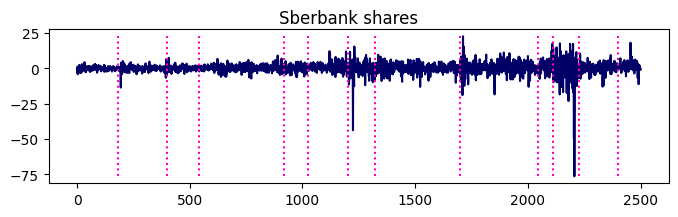

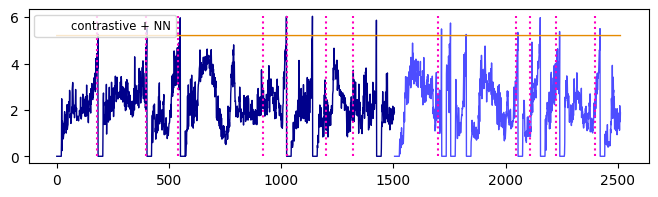

In [96]:
plt.rcParams["figure.figsize"] = (8,2)
plot_data_with_cp_sber(df, changepoints=change_points)
plt.show()

s_nn_train = np.concatenate([S_nn_train, np.array([0] * (data_val.shape[0] - S_nn_train.shape[0]))])
all_data = s_nn.shape[0]

plt.plot(s_nn_train,  color="darkblue", lw=1)
plt.plot(range(s_nn_train.shape[0], s_nn_train.shape[0] + S_nn_test.shape[0]), S_nn_test, color="#4d4dff", lw=1)
plt.plot([z] * all_data, color="#e68a00", lw=1)
plt.plot(1, lw=0, label="contrastive + NN")
plt.vlines(x=change_points,  ymin=s_nn.min(), ymax=s_nn.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.legend(loc='upper left', fontsize='small')

#### With a linear class

In [64]:
# TRAIN

verbose = True
min_diff = 10

p = 4

#----------------------------------------------------
# Step 1: tune the threshold on the stationary part
#----------------------------------------------------
    

S_stationary = np.empty(0)
for ds in data_stationary:
        
    S, _ = compute_test_stat_linear(ds, p, design='poly', delta_max=70)
    S_stationary = np.append(S_stationary, S)
        
# Set the threshold as the maximal value on the stationary part
z = np.max(S_stationary)
print(f'Threshold interval: {z} ± 1')


z = 4.4

#----------------------------------------------------
# Step 2: skip the validation part, because there are
# no parameters to tune
#----------------------------------------------------

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print(change_points_val)


# Initialization of the test statistic
S_lin_train = np.empty(0)

# Initialization of the list of detected change points
change_points_lin = []

# Initialization of the delays array and
# the false alarms counter
delays_lin = np.empty(0)
current_change_point_ind = 0
false_alarms_lin = 0


# Initialization
st_lin = 0
new_st_lin = 0
    
while new_st_lin >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_lin, new_st_lin = compute_test_stat_linear(data_val[st_lin + 1:], p,\
                                                     design='poly', threshold=z, delta_max=70)

    S_lin_train = np.append(S_lin_train, new_S_lin)

    st_lin += new_st_lin
    change_points_lin += [int(st_lin)]

    if(new_st_lin > 0):
        if verbose:  
            print('Detected change point:', st_lin)
            
        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_lin > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_lin += 1
        else:
            skipped_cp = 0

            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_lin:
                if skipped_cp > 0:
                    delays_lin = np.append(delays_lin, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_lin <= min_diff):
                delays_lin = np.append(delays_lin, np.array([0.0]), axis=0)
                if skipped_cp > 0:
                    delays_lin = np.append(delays_lin, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue


            delays_lin = np.append(delays_lin,\
                                   np.array([st_lin - change_points_val[current_change_point_ind - 1]]), axis=0)
            

while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_lin = np.append(delays_lin, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_lin = np.append(delays_lin, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1   
print('Linear class. Number of false alarms:', false_alarms_lin,\
      '; average delay:', np.mean(delays_lin), '±', np.std(delays_lin))

Threshold interval: 3.3928118083228442 ± 1
[ 180  398  540  920 1025 1200 1320]
Detected change point: 204
Detected change point: 399
Detected change point: 530
Detected change point: 592
False Alarm
Detected change point: 1122
Detected change point: 1230
Detected change point: 1421
Linear class. Number of false alarms: 1 ; average delay: 51.142857142857146 ± 44.405368309404636


In [66]:
# TEST
verbose = True
min_diff = 10
p = 4
z = 4.4

#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

# Change points on the test set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_lin_test = np.empty(0)

# Initialization of the list of detected change points
change_points_lin = []

# Initialization of the delays array and
# the false alarms counter
delays_lin = np.empty(0)
current_change_point_ind = 0
false_alarms_lin = 0


# Initialization
st_lin = 0
new_st_lin = 0
    
while new_st_lin >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_lin, new_st_lin = compute_test_stat_linear(data_test[st_lin + 1:], p,\
                                                     design='poly', threshold=z, delta_max=70)

    S_lin_test = np.append(S_lin_test, new_S_lin)

    st_lin += new_st_lin
    change_points_lin += [int(st_lin)]

    if(new_st_lin > 0):
        if verbose:  
            print('Detected change point:', st_lin)
            
        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_lin > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_lin += 1
        else:
            skipped_cp = 0

            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_lin:

                if skipped_cp > 0:
                    delays_lin = np.append(delays_lin, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_lin <= min_diff):
                delays_lin = np.append(delays_lin, np.array([0.0]), axis=0)

                if skipped_cp > 0:
                    delays_lin = np.append(delays_lin, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue


            delays_lin = np.append(delays_lin,\
                                   np.array([st_lin - change_points_test[current_change_point_ind - 1]]), axis=0)
            

while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_lin = np.append(delays_lin, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break

    delays_lin = np.append(delays_lin, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1   
print('Linear class. Number of false alarms:', false_alarms_lin,\
      '; average delay:', np.mean(delays_lin), '±', np.std(delays_lin))

Test change points: [200 545 610 725 900]
Detected change point: 209
Detected change point: 233
False Alarm
Detected change point: 542
Detected change point: 635
Detected change point: 730
Detected change point: 906
Linear class. Number of false alarms: 1 ; average delay: 9.0 ± 8.508818954473059


In [68]:
# joblib.dump(S_lin_test, "stats/S_lin_test_Sberbank.joblib")

['stats/S_lin_test_Sberbank.joblib']

##### Final plot

In [69]:
s_lin = np.concatenate([S_lin_train, np.array([0] * (data_val.shape[0] - S_lin_train.shape[0])), S_lin_test])
s_lin.shape

(2512,)

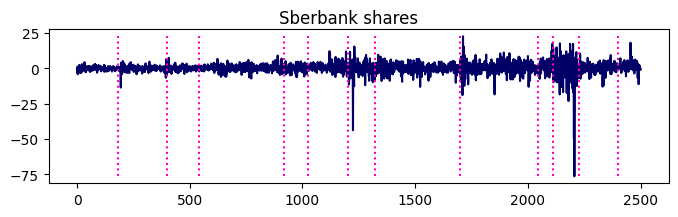

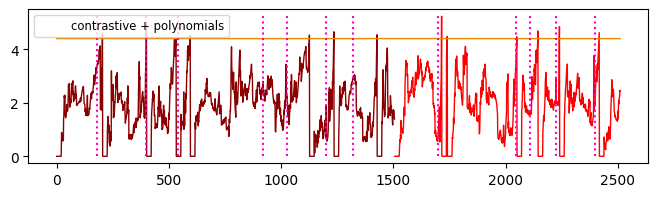

In [93]:
plt.rcParams["figure.figsize"] = (8,2)
plot_data_with_cp_sber(df, changepoints=change_points)
plt.show()

s_lin_train = np.concatenate([S_lin_train, np.array([0] * (data_val.shape[0] - S_lin_train.shape[0]))])
all_data = s_lin.shape[0]

plt.plot(s_lin_train,  color="darkred", lw=1)
plt.plot(range(s_lin_train.shape[0], s_lin_train.shape[0] + S_lin_test.shape[0]), S_lin_test, color="red", lw=1)
plt.plot([z] * all_data, color="#e68a00", lw=1)
plt.plot(1, lw=0, label="contrastive + polynomials")
plt.vlines(x=change_points,  ymin=s_lin.min(), ymax=s_lin.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.legend(loc='upper left', fontsize='small')

### Fast contrastive change point detection algorithm

#### With Hermite polynomials

In [99]:
verbose = False
min_diff = 10

p = 4

# The list of hyperparameters
beta_list = [0.01, 0.03, 0.1, 0.5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for b in beta_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_ftal(ds, p, beta=b, design='hermite', delta_max=70)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    zs = np.linspace(z - 1, z+1, 10)
    print(zs)
    
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
    # Initialization of the test statistic
        S_ftal = np.empty(0)

        # Initialization of the list of detected change points
        change_points_ftal = []

        # Initialization of the delays array and
        # the false alarms counter
        delays_ftal = np.empty(0)
        current_change_point_ind = 0
        false_alarms_ftal = 0

        # Initialization
        st_ftal = 0
        new_st_ftal = 0
        
        while new_st_ftal >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            try:
                new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_val[st_ftal + 1:], p, beta=b,\
                                                        design='hermite', threshold=z,  delta_max=70)
            except ValueError:
                print(f"Matrix is not positive semi definite")
                break
            
            S_ftal = np.append(S_ftal, new_S_ftal)

            st_ftal += new_st_ftal
            change_points_ftal += [int(st_ftal)]

            if(new_st_ftal > 0):
                if verbose:  
                    print('Detected change point:', st_ftal)

                if (current_change_point_ind >= len(change_points_val)\
                    or (change_points_val[current_change_point_ind] - st_ftal > min_diff)):
                    if verbose: 
                        print("False Alarm")
                    false_alarms_ftal += 1
                else:
                    skipped_cp = 0
                    
                    while current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] <= st_ftal:
                        
                        if skipped_cp > 0:
                            delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                        skipped_cp += 1


                        current_change_point_ind += 1

                    if (current_change_point_ind < len(change_points_val)\
                        and change_points_val[current_change_point_ind] - st_ftal <= min_diff):
                        delays_ftal = np.append(delays_ftal, np.array([0.0]), axis=0)
                        
                        if skipped_cp > 0:
                            delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                        current_change_point_ind += 1
                        continue

                    delays_ftal = np.append(delays_ftal,\
                                        np.array([st_ftal - change_points_val[current_change_point_ind - 1]]),\
                                            axis=0)
                    
        while current_change_point_ind < len(change_points_val):
            if current_change_point_ind == len(change_points_val) - 1:
                delays_ftal = np.append(delays_ftal, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                break

            delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
            current_change_point_ind += 1

        print(f'FTAL, threshold = {z}, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
            '; average delay:', np.mean(delays_ftal), '±', np.std(delays_ftal), '\n')

Validation change points: [ 180  398  540  920 1025 1200 1320]
[0.46488138 0.6871036  0.90932583 1.13154805 1.35377027 1.57599249
 1.79821471 2.02043694 2.24265916 2.46488138]
FTAL, threshold = 0.46488138116545175, beta = 0.01 . Number of false alarms: 23 ; average delay: 11.714285714285714 ± 10.333223611442927 

FTAL, threshold = 0.687103603387674, beta = 0.01 . Number of false alarms: 21 ; average delay: 24.285714285714285 ± 34.73456197965317 

FTAL, threshold = 0.9093258256098962, beta = 0.01 . Number of false alarms: 13 ; average delay: 21.428571428571427 ± 18.492138428896464 

FTAL, threshold = 1.1315480478321183, beta = 0.01 . Number of false alarms: 10 ; average delay: 43.42857142857143 ± 39.35500383090582 

FTAL, threshold = 1.3537702700543406, beta = 0.01 . Number of false alarms: 6 ; average delay: 46.142857142857146 ± 38.401743157713824 

FTAL, threshold = 1.575992492276563, beta = 0.01 . Number of false alarms: 4 ; average delay: 70.28571428571429 ± 40.92402118810029 

FTAL

In [97]:
#TRAIN
verbose = True
min_diff = 10
z = 2.3
b = 0.03

p = 4

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)

# Initialization of the test statistic
S_ftal_train = np.empty(0)

# Initialization of the list of detected change points
change_points_ftal = []

# Initialization of the delays array and
# the false alarms counter
delays_ftal = np.empty(0)
current_change_point_ind = 0
false_alarms_ftal = 0

# Initialization
st_ftal = 0
new_st_ftal = 0

while new_st_ftal >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    try:
        new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_val[st_ftal + 1:], p, beta=b,\
                                                design='hermite', threshold=z,  delta_max=70)
    except ValueError:
        print(f"Matrix is not positive semi definite")
        break
    
    S_ftal_train = np.append(S_ftal_train, new_S_ftal)

    st_ftal += new_st_ftal
    change_points_ftal += [int(st_ftal)]

    if(new_st_ftal > 0):
        if verbose:  
            print('Detected change point:', st_ftal)

        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_ftal > min_diff)):
            if verbose: 
                print("False Alarm")
            false_alarms_ftal += 1
        else:
            skipped_cp = 0
            
            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_ftal:
                
                if skipped_cp > 0:
                    delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1


                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_ftal <= min_diff):
                delays_ftal = np.append(delays_ftal, np.array([0.0]), axis=0)
                
                if skipped_cp > 0:
                    delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_ftal = np.append(delays_ftal,\
                                np.array([st_ftal - change_points_val[current_change_point_ind - 1]]),\
                                    axis=0)
            
while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_ftal = np.append(delays_ftal, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_ftal = np.append(delays_ftal, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print(f'FTAL, threshold = {z}, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
    '; average delay:', np.mean(delays_ftal), '±', np.std(delays_ftal), '\n')

Validation change points: [ 180  398  540  920 1025 1200 1320]
Detected change point: 181
Detected change point: 314
False Alarm
Detected change point: 402
Detected change point: 518
False Alarm
Detected change point: 580
Detected change point: 1098
Detected change point: 1224
Detected change point: 1419
FTAL, threshold = 2.3, beta = 0.03 . Number of false alarms: 2 ; average delay: 49.42857142857143 ± 40.081549524000415 



In [56]:
#TEST
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------
verbose=True
min_diff = 10
z = 2.3
b = 0.03

# Change points on the validation set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)
    
# Initialization of the test statistic
S_ftal_test = np.empty(0)

# Initialization of the list of detected change points
change_points_ftal = []

# Initialization of the delays array and the false alarms counter
delays_ftal = np.empty(0)
current_change_point_ind = 0
false_alarms_ftal = 0

# Initialization
st_ftal = 0
new_st_ftal = 0
    
while new_st_ftal >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_ftal, new_st_ftal = compute_test_stat_ftal(data_test[st_ftal + 1:], p, beta=b,\
                                                       design='hermite', threshold=z,  delta_max=70)

    S_ftal_test = np.append(S_ftal_test, new_S_ftal)

    st_ftal += new_st_ftal
    change_points_ftal += [int(st_ftal)]
    if(new_st_ftal > 0):
        if verbose:  
            print('Detected change point:', st_ftal)

        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_ftal > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_ftal += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_ftal:
                
                if skipped_cp > 0:
                    delays_ftal = np.append(delays_ftal, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_ftal <= min_diff):
                delays_ftal = np.append(delays_ftal, np.array([0.0]), axis=0)
                if skipped_cp > 0:
                    delays_ftal = np.append(delays_ftal, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)
                
                current_change_point_ind += 1
                continue
            
            delays_ftal = np.append(delays_ftal,\
                                   np.array([st_ftal - change_points_test[current_change_point_ind - 1]]),\
                                    axis=0)

            
while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_ftal = np.append(delays_ftal, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break
    delays_ftal = np.append(delays_ftal, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print('FTAL, beta =', b, '. Number of false alarms:', false_alarms_ftal,\
      '; average delay:', np.mean(delays_ftal), '±', np.std(delays_ftal))

Test change points: [200 545 610 725 900]
Detected change point: 91
False Alarm
Detected change point: 208
Detected change point: 639
Detected change point: 741
Detected change point: 901
FTAL, beta = 0.03 . Number of false alarms: 1 ; average delay: 23.8 ± 22.604424345689498


In [105]:
# joblib.dump(S_ftal_test,  'stats/S_hermite_test.joblib')

['stats/S_hermite_test.joblib']

##### Final plot

In [99]:
s_ftal = np.concatenate([S_ftal_train, np.array([0] * (data_val.shape[0] - S_ftal_train.shape[0])), S_ftal_test])
s_ftal.shape

(2514,)

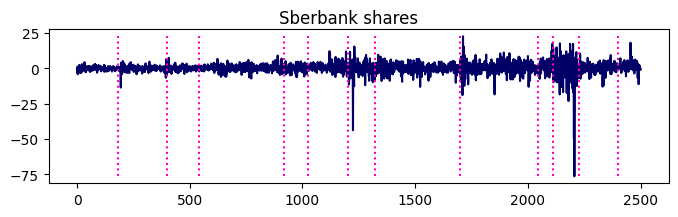

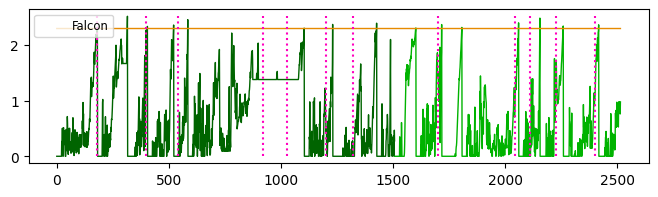

In [100]:
plt.rcParams["figure.figsize"] = (8,2)
plot_data_with_cp_sber(df, changepoints=change_points)
plt.show()

s_ftal_train = np.concatenate([S_ftal_train, np.array([0] * (data_val.shape[0] - S_ftal_train.shape[0]))])
all_data = s_ftal.shape[0]

plt.plot(s_ftal_train,  color="darkgreen", lw=1)
plt.plot(range(s_ftal_train.shape[0], s_ftal_train.shape[0] + S_ftal_test.shape[0]), S_ftal_test, color="#00b300", lw=1)
plt.plot([z] * all_data, color="#e68a00", lw=1)
plt.plot(1, lw=0, label="Falcon")
plt.vlines(x=change_points,  ymin=s_ftal.min(), ymax=s_ftal.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.legend(loc='upper left', fontsize='small')

### KLIEP

In [ ]:
verbose = False
min_diff = 10

# The list of hyperparameters
sigma_list = [0.05, 0.5, 0.9, 1, 5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_kliep(ds, window_size=60, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    zs = np.linspace(z+3, z+16, 10)
    print(zs)
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        # Initialization of the test statistic
        S_kliep = np.empty(0)

        # Initialization of the list of detected change points
        change_points_kliep = []

        # Initialization of the delays array and
        # the false alarms counter
        delays_kliep = np.empty(0)
        current_change_point_ind = 0
        false_alarms_kliep = 0

        # Initialization
        st_kliep = 0
        new_st_kliep = 0
        
        while new_st_kliep >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_val[st_kliep + 1:],\
                                                                window_size=60, sigma=sigma, threshold=z)

            S_kliep = np.append(S_kliep, new_S_kliep)

            st_kliep += new_st_kliep
            change_points_kliep += [int(st_kliep)]

            if(new_st_kliep > 0):
                if verbose:  
                    print('Detected change point:', st_kliep)

                if (current_change_point_ind >= len(change_points_val)\
                    or (change_points_val[current_change_point_ind] - st_kliep > min_diff)):
                    if verbose:
                        print("False Alarm")
                    false_alarms_kliep += 1
                else:
                    skipped_cp = 0
                    while current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] <= st_kliep:
                        
                        if skipped_cp > 0:
                            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                        skipped_cp += 1


                        current_change_point_ind += 1

                    if (current_change_point_ind < len(change_points_val)\
                        and change_points_val[current_change_point_ind] - st_kliep <= min_diff):
                        delays_kliep = np.append(delays_kliep, np.array([0.0]), axis=0)

                        if skipped_cp > 0:
                            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                        current_change_point_ind += 1
                        continue

                    delays_kliep = np.append(delays_kliep,\
                                        np.array([st_kliep - change_points_val[current_change_point_ind - 1]]),\
                                            axis=0)
                    
        while current_change_point_ind < len(change_points_val):
            if current_change_point_ind == len(change_points_val) - 1:
                delays_kliep = np.append(delays_kliep, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                break

            delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
            current_change_point_ind += 1


        print(f'KLIEP, threshold: {z}, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
            '; average delay:', np.mean(delays_kliep), '±', np.std(delays_kliep))

Validation change points: [ 180  398  540  920 1025 1200 1320]
[105.21984246 106.6642869  108.10873135 109.55317579 110.99762024
 112.44206468 113.88650913 115.33095357 116.77539801 118.21984246]
KLIEP, threshold: 105.21984245930278, sigma = 0.05 . Number of false alarms: 2 ; average delay: 50.42857142857143 ± 35.900088113131595
KLIEP, threshold: 106.66428690374723, sigma = 0.05 . Number of false alarms: 2 ; average delay: 54.857142857142854 ± 35.882461181030536
KLIEP, threshold: 108.10873134819167, sigma = 0.05 . Number of false alarms: 2 ; average delay: 64.0 ± 33.14901420641559
KLIEP, threshold: 109.55317579263611, sigma = 0.05 . Number of false alarms: 2 ; average delay: 66.85714285714286 ± 34.65102996378348
KLIEP, threshold: 110.99762023708055, sigma = 0.05 . Number of false alarms: 2 ; average delay: 67.28571428571429 ± 34.69340936058641
KLIEP, threshold: 112.44206468152501, sigma = 0.05 . Number of false alarms: 2 ; average delay: 67.28571428571429 ± 34.69340936058641
KLIEP, thr

In [80]:
#TRAIN
sigma = 0.9
z = 22.93537121307712
min_diff = 10
verbose=True


# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)

S_kliep_train = np.empty(0)

# Initialization of the list of detected change points
change_points_kliep = []

# Initialization of the delays array and
# the false alarms counter
delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0

# Initialization
st_kliep = 0
new_st_kliep = 0

while new_st_kliep >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_val[st_kliep + 1:],\
                                                        window_size=60, sigma=sigma, threshold=z)

    S_kliep_train = np.append(S_kliep_train, new_S_kliep)

    st_kliep += new_st_kliep
    change_points_kliep += [int(st_kliep)]

    if(new_st_kliep > 0):
        if verbose:  
            print('Detected change point:', st_kliep)

        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_kliep > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_kliep += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_kliep:
                if skipped_cp > 0:
                    delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1


                current_change_point_ind += 1
            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_kliep <= min_diff):
                delays_kliep = np.append(delays_kliep, np.array([0.0]), axis=0)
                
                if skipped_cp > 0:
                    delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_kliep = np.append(delays_kliep,\
                                np.array([st_kliep - change_points_val[current_change_point_ind - 1]]),\
                                    axis=0)
            
while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_kliep = np.append(delays_kliep, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_kliep = np.append(delays_kliep, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1
print('KLIEP, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
    '; average delay:', np.mean(delays_kliep), '±', np.std(delays_kliep))

Validation change points: [ 180  398  540  920 1025 1200 1320]
Detected change point: 212
Detected change point: 435
Detected change point: 623
Detected change point: 785
False Alarm
Detected change point: 919
Detected change point: 1112
Detected change point: 1233
Detected change point: 1354
KLIEP, sigma = 0.9 . Number of false alarms: 1 ; average delay: 43.714285714285715 ± 28.584282822729627


In [81]:
#TEST
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

sigma = 0.9
z = 22.93537121307712
min_diff = 10
verbose=True
    
# Change points on the validation set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_kliep_test = np.empty(0)

# Initialization of the list of detected change points
change_points_kliep = []

# Initialization of the delays array and
# the false alarms counter
delays_kliep = np.empty(0)
current_change_point_ind = 0
false_alarms_kliep = 0

# Initialization
st_kliep = 0
new_st_kliep = 0
    
while new_st_kliep >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_kliep, new_st_kliep = compute_test_stat_kliep(data_test[st_kliep + 1:],\
                                                        window_size=50, sigma=sigma, threshold=z)

    S_kliep_test = np.append(S_kliep_test, new_S_kliep)

    st_kliep += new_st_kliep
    change_points_kliep += [int(st_kliep)]

    if(new_st_kliep > 0):
        if verbose:  
            print('Detected change point:', st_kliep)

        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_kliep > min_diff)):
            print("False Alarm")
            false_alarms_kliep += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_kliep:
                if skipped_cp > 0:
                    delays_kliep = np.append(delays_kliep, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_kliep <= min_diff):
                delays_kliep = np.append(delays_kliep, np.array([0.0]), axis=0)
                
                if skipped_cp > 0:
                    delays_kliep = np.append(delays_kliep, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_kliep = np.append(delays_kliep,\
                                   np.array([st_kliep - change_points_test[current_change_point_ind - 1]]),\
                                    axis=0)

while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_kliep = np.append(delays_kliep, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break

    delays_kliep = np.append(delays_kliep, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1
    
print('KLIEP, sigma =', sigma, '. Number of false alarms:', false_alarms_kliep,\
      '; average delay:', np.mean(delays_kliep), '±', np.std(delays_kliep))

Test change points: [200 545 610 725 900]
Detected change point: 205
Detected change point: 392
False Alarm
Detected change point: 601
Detected change point: 702
False Alarm
Detected change point: 803
KLIEP, sigma = 0.9 . Number of false alarms: 2 ; average delay: 49.8 ± 40.33559222324621


In [166]:
# joblib.dump(S_kliep_test, "stats/S_kliep_test.joblib")

['stats/S_kliep_test.joblib']

#### Final plot

In [82]:
s_k = np.concatenate([S_kliep_train, np.array([0] * (data_val.shape[0] - S_kliep_train.shape[0])), S_kliep_test])
s_k.shape

(2512,)

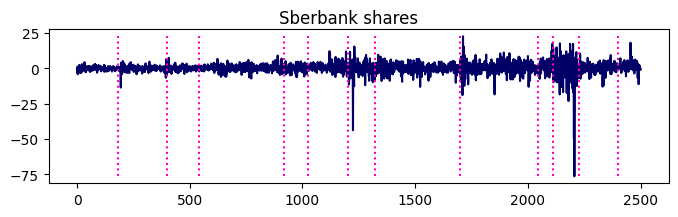

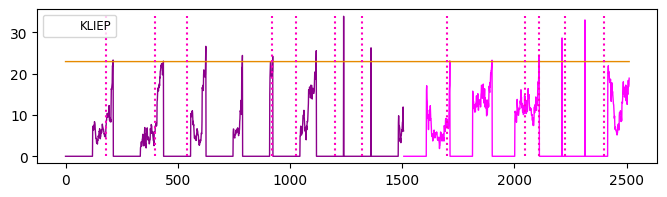

In [94]:
s_k = np.concatenate([S_kliep_train, np.array([0] * (data_val.shape[0] - S_kliep_train.shape[0])), S_kliep_test])
s_k.shape
plt.rcParams["figure.figsize"] = (8,2)
plot_data_with_cp_sber(df, changepoints=change_points)
plt.show()

s_k_train = np.concatenate([S_kliep_train, np.array([0] * (data_val.shape[0] - S_kliep_train.shape[0]))])
all_data = s_k.shape[0]

plt.plot(s_k_train, color="darkmagenta", lw=1)
plt.plot(range(s_k_train.shape[0], s_k_train.shape[0] + S_kliep_test.shape[0]), S_kliep_test, color="magenta", lw=1)
plt.plot([z] * all_data, color="#e68a00", lw=1)
plt.plot(1, lw=0, label="KLIEP")
plt.vlines(x=change_points,  ymin=s_k.min(), ymax=s_k.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.legend(loc='upper left', fontsize='small')

### M-statistic 

In [38]:
verbose = False
min_diff = 10

# The list of hyperparameters
sigma_list = [0.05, 0.1, 0.5, 1, 5]

# Change points on the validation set
change_points_val = change_points[change_points < val_end] - val_start
change_points_val = change_points_val[change_points_val > 0]
print('Validation change points:', change_points_val)
    
for sigma in sigma_list:
    
    #----------------------------------------------------
    # Step 1: tuning the threshold on the stationary part
    #----------------------------------------------------
    
    S_stationary = np.empty(0)
    for ds in data_stationary:
        
        S, _ = compute_test_stat_mmd(ds, window_size=70, sigma=sigma)
        S_stationary = np.append(S_stationary, S)
        
    # Set the threshold as the maximal value on the stationary part
    z = np.max(S_stationary)
    
    zs = np.linspace(z-2, z+6, 10)
    print(zs)
    #----------------------------------------------------
    # Step 2: detect changes on the validation part
    #----------------------------------------------------
    for z in zs:
        # Initialization of the test statistic
        S_mmd = np.empty(0)

        # Initialization of the list of detected change points
        change_points_mmd = []

        # Initialization of the delays array and
        # the false alarms counter
        delays_mmd = np.empty(0)
        current_change_point_ind = 0
        false_alarms_mmd = 0

        # Initialization
        st_mmd = 0
        new_st_mmd = 0
        
        while new_st_mmd >= 0:

            # Run the procedure until the moment
            # it reports a change point occurrence
            new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                                window_size=70, sigma=sigma, threshold=z)

            S_mmd = np.append(S_mmd, new_S_mmd)

            st_mmd += new_st_mmd
            change_points_mmd += [int(st_mmd)]

            if(new_st_mmd  > 0):
                if verbose:  
                    print('Detected change point:', st_mmd )

                if (current_change_point_ind >= len(change_points_val)\
                    or (change_points_val[current_change_point_ind] - st_mmd  > min_diff)):
                    if verbose:
                        print("False Alarm")
                    false_alarms_mmd  += 1
                else:
                    skipped_cp = 0
                    while current_change_point_ind < len(change_points_val)\
                    and change_points_val[current_change_point_ind] <= st_mmd :
                        if skipped_cp > 0:
                            delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                        skipped_cp += 1

                        current_change_point_ind += 1
                    
                    if (current_change_point_ind < len(change_points_val)\
                        and change_points_val[current_change_point_ind] - st_mmd  <= min_diff):
                        delays_mmd  = np.append(delays_mmd , np.array([0.0]), axis=0)

                        if skipped_cp > 0:
                            delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                        current_change_point_ind += 1
                        continue

                    delays_mmd  = np.append(delays_mmd ,\
                                        np.array([st_mmd - change_points_val[current_change_point_ind - 1]]),\
                                            axis=0) 
                    
        while current_change_point_ind < len(change_points_val):
            if current_change_point_ind == len(change_points_val) - 1:
                delays_mmd = np.append(delays_mmd, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
                break

            delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
            current_change_point_ind += 1
        print(f'M-statistic, threshold: {z} sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
            '; average delay:', np.mean(delays_mmd), '±', np.std(delays_mmd))

Validation change points: [ 180  398  540  920 1025 1200 1320]
[ 9.08870128  9.97759016 10.86647905 11.75536794 12.64425683 13.53314572
 14.42203461 15.3109235  16.19981239 17.08870128]
M-statistic, threshold: 9.08870127558958 sigma = 0.05 . Number of false alarms: 2 ; average delay: 65.42857142857143 ± 34.5867734540125
M-statistic, threshold: 9.97759016447847 sigma = 0.05 . Number of false alarms: 3 ; average delay: 101.28571428571429 ± 59.50681662204588
M-statistic, threshold: 10.866479053367357 sigma = 0.05 . Number of false alarms: 2 ; average delay: 104.28571428571429 ± 70.72020177272906
M-statistic, threshold: 11.755367942256246 sigma = 0.05 . Number of false alarms: 0 ; average delay: 113.28571428571429 ± 36.52675843313575
M-statistic, threshold: 12.644256831145135 sigma = 0.05 . Number of false alarms: 0 ; average delay: 154.42857142857142 ± 98.64055547123338
M-statistic, threshold: 13.533145720034025 sigma = 0.05 . Number of false alarms: 0 ; average delay: 188.57142857142858 

In [84]:
#TRAIN
z =  1.9475447
sigma = 5
verbose=True

# Initialization of the test statistic
S_mmd_train = np.empty(0)

# Initialization of the list of detected change points
change_points_mmd = []

# Initialization of the delays array and
# the false alarms counter
delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

# Initialization
st_mmd = 0
new_st_mmd = 0

while new_st_mmd >= 0:

    # Run the procedure until the moment
    # it reports a change point occurrence
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_val[st_mmd + 1:],\
                                                        window_size=70, sigma=sigma, threshold=z)

    S_mmd_train = np.append(S_mmd_train, new_S_mmd)

    st_mmd += new_st_mmd
    change_points_mmd += [int(st_mmd)]

    if(new_st_mmd  > 0):
        if verbose:  
            print('Detected change point:', st_mmd )

        if (current_change_point_ind >= len(change_points_val)\
            or (change_points_val[current_change_point_ind] - st_mmd  > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_mmd  += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_val)\
            and change_points_val[current_change_point_ind] <= st_mmd :
                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1
            
            if (current_change_point_ind < len(change_points_val)\
                and change_points_val[current_change_point_ind] - st_mmd  <= min_diff):
                delays_mmd  = np.append(delays_mmd , np.array([0.0]), axis=0)

                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind] - change_points_val[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_mmd  = np.append(delays_mmd ,\
                                np.array([st_mmd - change_points_val[current_change_point_ind - 1]]),\
                                    axis=0) 
            
while current_change_point_ind < len(change_points_val):
    if current_change_point_ind == len(change_points_val) - 1:
        delays_mmd = np.append(delays_mmd, np.array([len(data_val) - change_points_val[current_change_point_ind]]), axis=0)
        break

    delays_mmd = np.append(delays_mmd, np.array([change_points_val[current_change_point_ind + 1] - change_points_val[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1
print(f'M-statistic, threshold: {z} sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
    '; average delay:', np.mean(delays_mmd), '±', np.std(delays_mmd))

Detected change point: 201
Detected change point: 437
Detected change point: 614
Detected change point: 784
False Alarm
Detected change point: 928
Detected change point: 1081
Detected change point: 1222
Detected change point: 1430
M-statistic, threshold: 1.9475447 sigma = 5 . Number of false alarms: 1 ; average delay: 47.142857142857146 ± 33.09047584784381


In [85]:
#TEST
#----------------------------------------------------
# Step 3: detect changes on the test part
#----------------------------------------------------

z =  1.9475447
sigma = 5
verbose=True
    
# Change points on the validation set
change_points_test = change_points - test_start
change_points_test = change_points_test[change_points_test > 0]
print('Test change points:', change_points_test)

# Initialization of the test statistic
S_mmd_test = np.empty(0)

# Initialization of the list of detected change points
change_points_mmd = []

# Initialization of the delays array and
# the false alarms counter
delays_mmd = np.empty(0)
current_change_point_ind = 0
false_alarms_mmd = 0

# Initialization
st_mmd = 0
new_st_mmd = 0
    
while new_st_mmd >= 0:

    # Run the procedure until the moment it reports a change point occurrence
    new_S_mmd, new_st_mmd = compute_test_stat_mmd(data_test[st_mmd + 1:],\
                                                        window_size=70, sigma=sigma, threshold=z)

    S_mmd_test = np.append(S_mmd_test, new_S_mmd)

    st_mmd += new_st_mmd
    change_points_mmd += [int(st_mmd)]

    if(new_st_mmd > 0):
        if verbose:  
            print('Detected change point:', st_mmd)

        if (current_change_point_ind >= len(change_points_test)\
            or (change_points_test[current_change_point_ind] - st_mmd > min_diff)):
            if verbose:
                print("False Alarm")
            false_alarms_mmd += 1
        else:
            skipped_cp = 0
            while current_change_point_ind < len(change_points_test)\
            and change_points_test[current_change_point_ind] <= st_mmd :
                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)     
                skipped_cp += 1

                current_change_point_ind += 1

            if (current_change_point_ind < len(change_points_test)\
                and change_points_test[current_change_point_ind] - st_mmd <= min_diff):
                delays_mmd = np.append(delays_mmd, np.array([0.0]), axis=0)


                if skipped_cp > 0:
                    delays_mmd = np.append(delays_mmd, np.array([change_points_test[current_change_point_ind] - change_points_test[current_change_point_ind - 1]]), axis=0)

                current_change_point_ind += 1
                continue

            delays_mmd = np.append(delays_mmd,\
                                   np.array([st_mmd - change_points_test[current_change_point_ind - 1]]),\
                                    axis=0)

while current_change_point_ind < len(change_points_test):
    if current_change_point_ind == len(change_points_test) - 1:
        delays_mmd = np.append(delays_mmd, np.array([len(data_test) - change_points_test[current_change_point_ind]]), axis=0)
        break

    delays_mmd = np.append(delays_mmd, np.array([change_points_test[current_change_point_ind + 1] - change_points_test[current_change_point_ind]]), axis=0)
    current_change_point_ind += 1

print('M-statistic, sigma =', sigma, '. Number of false alarms:', false_alarms_mmd,\
      '; average delay:', np.mean(delays_mmd), '±', np.std(delays_mmd))

Test change points: [200 545 610 725 900]
Detected change point: 143
False Alarm
Detected change point: 285
Detected change point: 426
False Alarm
Detected change point: 616
Detected change point: 763
Detected change point: 912
M-statistic, sigma = 5 . Number of false alarms: 2 ; average delay: 41.2 ± 30.287951399855356


In [22]:
# joblib.dump(S_mmd_test, "stats/S_mmd_test.joblib")

['stats/S_mmd_test.joblib']

#### Final plot

In [86]:
s_m = np.concatenate([S_mmd_train, np.array([0] * (data_val.shape[0] - S_mmd_train.shape[0])), S_mmd_test])
s_m.shape

(2513,)

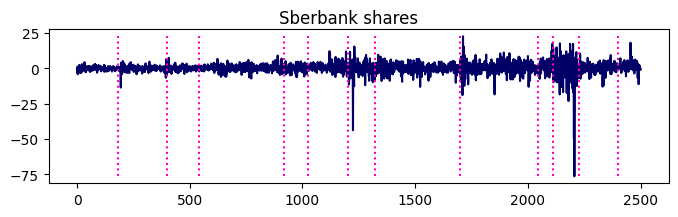

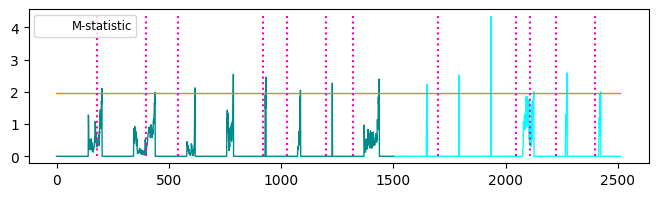

In [95]:
plt.rcParams["figure.figsize"] = (8,2)
plot_data_with_cp_sber(df, changepoints=change_points)
plt.show()

s_m_train = np.concatenate([S_mmd_train, np.array([0] * (data_val.shape[0] - S_mmd_train.shape[0]))])
all_data = s_m.shape[0]

plt.plot(s_m_train,  color="darkcyan", lw=1)
plt.plot(range(s_m_train.shape[0], s_m_train.shape[0] + S_mmd_test.shape[0]), S_mmd_test, color="cyan", lw=1)
plt.plot([z] * all_data, color="#e68a00", lw=1)
plt.plot(1, lw=0, label="M-statistic")
plt.vlines(x=change_points,  ymin=s_m.min(), ymax=s_m.max(), colors='#ff00bf', ls=':', lw=1.5)
plt.legend(loc='upper left', fontsize='small')